# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2023-02-19 22:25:02.443123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 22:25:03.366326: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aleks/miniconda3/envs/tf/lib/python3.10/site-packages/cv2/../../lib64::/home/aleks/miniconda3/envs/tf/lib/
2023-02-19 22:25:03.372950: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aleks/minic

2.11.0
True


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

ModuleNotFoundError: No module named 'matplotlib'

## Загружаем предобученную модель

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

2023-02-19 22:25:15.140251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:82:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-19 22:25:15.186577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:82:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-19 22:25:15.186666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:82:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-19 22:25:15.187242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [5]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [7]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [9]:
val_samples = 2500  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=100,  # число вызовов генератора за эпоху
          epochs=25,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/25


2023-02-19 22:26:30.931319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-19 22:26:32.490749: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-19 22:26:37.205312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-19 22:26:37.214207: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1cc4b380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-19 22:26:37.214273: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-02-19 22:26:37.222712: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-19 22:26:37.628036

100/100 [==============================] - 88s 789ms/step - loss: 0.2915 - accuracy: 0.8784 - val_loss: 0.1918 - val_accuracy: 0.9272
Epoch 2/25
100/100 [==============================] - 76s 768ms/step - loss: 0.1839 - accuracy: 0.9300 - val_loss: 0.1444 - val_accuracy: 0.9452
Epoch 3/25
100/100 [==============================] - 73s 733ms/step - loss: 0.1734 - accuracy: 0.9347 - val_loss: 0.1408 - val_accuracy: 0.9412
Epoch 4/25
100/100 [==============================] - 73s 741ms/step - loss: 0.1552 - accuracy: 0.9428 - val_loss: 0.1184 - val_accuracy: 0.9520
Epoch 5/25
100/100 [==============================] - 76s 767ms/step - loss: 0.1605 - accuracy: 0.9406 - val_loss: 0.1070 - val_accuracy: 0.9572
Epoch 6/25
100/100 [==============================] - 76s 767ms/step - loss: 0.1472 - accuracy: 0.9459 - val_loss: 0.1081 - val_accuracy: 0.9572
Epoch 7/25
100/100 [==============================] - 74s 745ms/step - loss: 0.1417 - accuracy: 0.9447 - val_loss: 0.1002 - val_accuracy: 0.9

In [8]:
model.save('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [10]:
test_files = glob('data/test/*.jpg')

In [11]:
len(test_files)

12500

In [12]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 279s 22ms/step


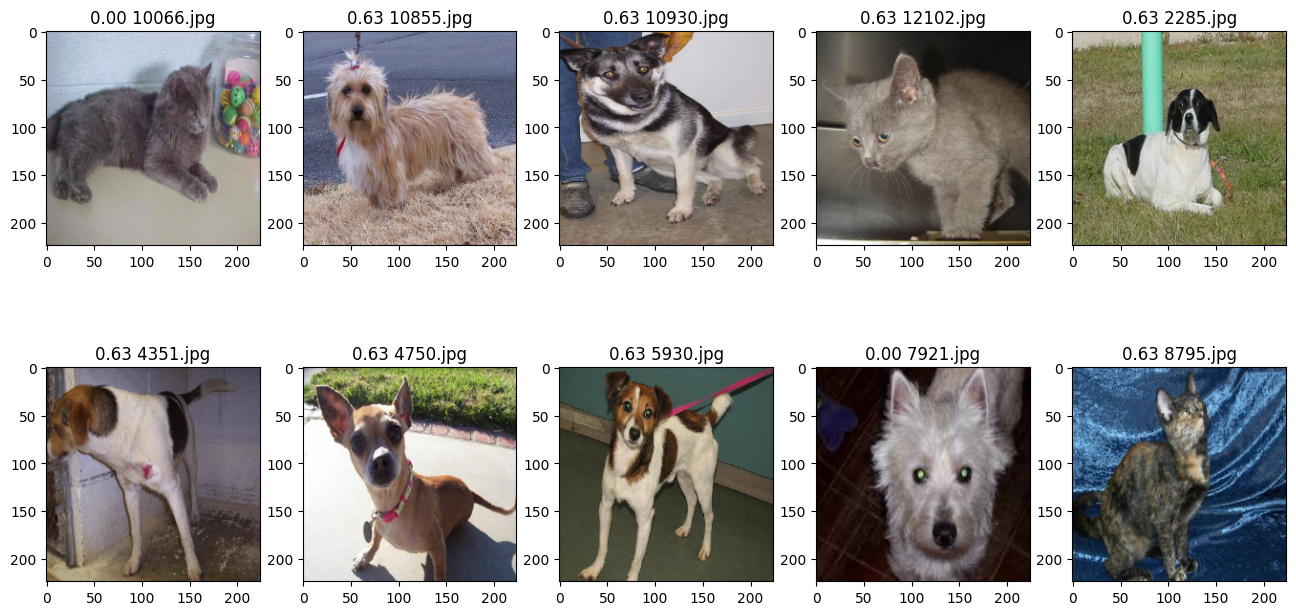

In [10]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [13]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
# LogLoss = 1.04979